In [49]:
import pandas as pd
import os
import pydicom as pyd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/haimin/PycharmProjects/end2end-all-conv/ddsm_train')
#from ddsm_train.sample_patches_combined import overlap_patch_roi
#from sample_patches_combined import crop_val
from scipy.misc import toimage



In [59]:
def print_image(im):

    ds = pyd.dcmread(im)
    plt.figure(figsize=(5, 10))  # displaying image size
    plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    plt.ylabel(im)
    plt.show()


In [60]:
image_path = '/home/haimin/Dicom/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017-DDSM-96009/1-full mammogram images-63992/000000.dcm'

img = pyd.read_file(image_path).pixel_array
img.shape


(4616, 3016)

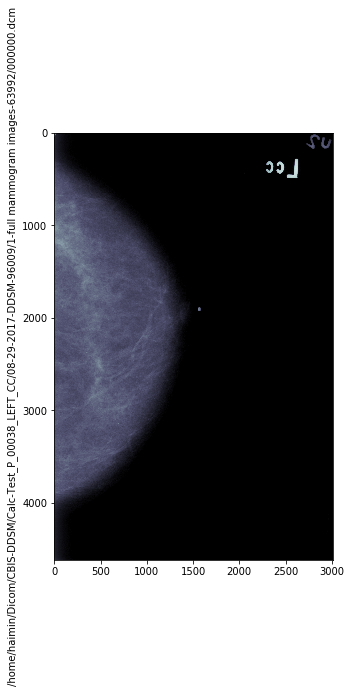

In [61]:
print_image(image_path)

In [62]:
#convert and apply treshhold
img_8u = (img.astype('float32')/img.max()*255).astype('uint8')
low_th = int(img_8u.max()*.05)

_, img_bin = cv2.threshold(img_8u, low_th, maxval=255, type=cv2.THRESH_BINARY)
img_bin

array([[255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       ...,
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0],
       [255, 255, 255, ...,   0,   0,   0]], dtype=uint8)

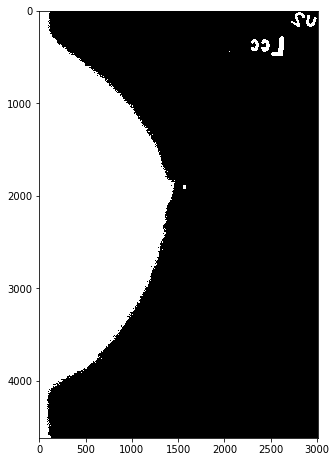

In [63]:
plt.figure(figsize=(5, 10))  # displaying image size
plt.imshow(img_bin, cmap=plt.cm.bone)
plt.show()

12137
idx:  4666
bbox:  0 0 1470 4616


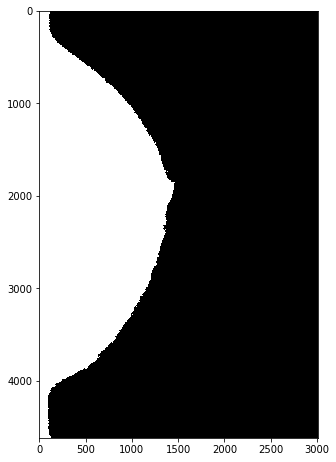

In [64]:
_, contours, _ = cv2.findContours(
                img_bin.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
cont_areas = [ cv2.contourArea(cont) for cont in contours ]
idx = np.argmax(cont_areas)  # find the largest contour, i.e. breast.
print 'idx: ', idx
breast_mask = cv2.drawContours(
            np.zeros_like(img_bin), contours, idx, 255, -1)  # fill the contour
plt.figure(figsize=(5, 10))  # displaying image size

plt.imshow(breast_mask, cmap=plt.cm.bone)

# get rectangular box for contour
x, y, w, h = cv2.boundingRect(contours[idx])
print 'bbox: ', x, y, w, h

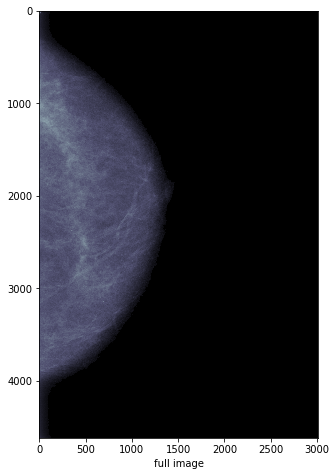

In [65]:
img_breast_only = cv2.bitwise_and(img, img, mask=breast_mask)
plt.figure(figsize=(5, 10))
plt.xlabel('full image')
plt.imshow(img_breast_only, cmap=plt.cm.bone)


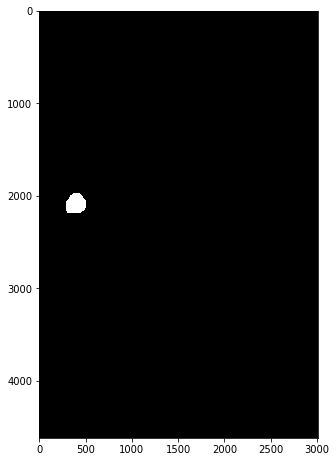

In [24]:
r_img = pyd.dcmread('/home/haimin/Dicom/CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-2017-DDSM-94942/1-ROI mask images-18515/000001.dcm')

plt.figure(figsize=(5, 10))
plt.imshow(r_img.pixel_array, cmap=plt.cm.bone)

In [50]:

def sample_patches(img, roi_mask, out_dir, img_id, abn, pos, patch_size=256,
                   pos_cutoff=.75, neg_cutoff=.35,
                   nb_bkg=100, nb_abn=100, start_sample_nb=0,
                   bkg_dir='background', pos_dir='malignant', neg_dir='benign', 
                   verbose=False):
    if pos:
        roi_out = os.path.join(out_dir, pos_dir)
    else:
        roi_out = os.path.join(out_dir, neg_dir)
    bkg_out = os.path.join(out_dir, bkg_dir)
    basename = '_'.join([img_id, str(abn)])

    img = add_img_margins(img, patch_size/2)
    roi_mask = add_img_margins(roi_mask, patch_size/2)
    # Get ROI bounding box.
    roi_mask_8u = roi_mask.astype('uint8')
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3:
        contours,_ = cv2.findContours(
            roi_mask_8u.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    else:
        _, contours, _ = cv2.findContours(
            roi_mask_8u.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cont_areas = [ cv2.contourArea(cont) for cont in contours ]
    idx = np.argmax(cont_areas)  # find the largest contour.
    rx,ry,rw,rh = cv2.boundingRect(contours[idx])
    if verbose:
        M = cv2.moments(contours[idx])
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        print "ROI centroid=", (cx,cy); sys.stdout.flush()

    rng = np.random.RandomState(12345)
    # Sample abnormality first.
    sampled_abn = 0
    nb_try = 0
    while sampled_abn < nb_abn:
        x = rng.randint(rx, rx + rw)
        y = rng.randint(ry, ry + rh)
        nb_try += 1
        if nb_try >= 1000:
            print "Nb of trials reached maximum, decrease overlap cutoff by 0.05"
            sys.stdout.flush()
            pos_cutoff -= .05
            nb_try = 0
            if pos_cutoff <= .0:
                raise Exception("overlap cutoff becomes non-positive, "
                                "check roi mask input.")
        # import pdb; pdb.set_trace()
        if overlap_patch_roi((x,y), patch_size, roi_mask, cutoff=pos_cutoff):
            patch = img[y - patch_size/2:y + patch_size/2, 
                        x - patch_size/2:x + patch_size/2]
            patch_img = toimage(
                patch.astype('int32'), high=patch.max(), low=patch.min(), 
                mode='I')
            # patch = patch.reshape((patch.shape[0], patch.shape[1], 1))
            filename = basename + "_%04d" % (sampled_abn) + ".png"
            fullname = os.path.join(roi_out, filename)
            # import pdb; pdb.set_trace()
            patch_img.save(fullname)
            sampled_abn += 1
            nb_try = 0
            if verbose:
                print "sampled an abn patch at (x,y) center=", (x,y)
                sys.stdout.flush()
    # Sample background.
    sampled_bkg = start_sample_nb
    while sampled_bkg < start_sample_nb + nb_bkg:
        x = rng.randint(patch_size/2, img.shape[1] - patch_size/2)
        y = rng.randint(patch_size/2, img.shape[0] - patch_size/2)
        if not overlap_patch_roi((x,y), patch_size, roi_mask, cutoff=neg_cutoff):
            patch = img[y - patch_size/2:y + patch_size/2, 
                        x - patch_size/2:x + patch_size/2]
            patch_img = toimage(
                patch.astype('int32'), high=patch.max(), low=patch.min(), 
                mode='I')
            filename = basename + "_%04d" % (sampled_bkg) + ".png"
            fullname = os.path.join(bkg_out, filename)
            patch_img.save(fullname)
            sampled_bkg += 1
            if verbose:
                print "sampled a bkg patch at (x,y) center=", (x,y)
                sys.stdout.flush()

In [51]:
def add_img_margins(img, margin_size):
    '''Add all zero margins to an image
    '''
    enlarged_img = np.zeros((img.shape[0]+margin_size*2, 
                             img.shape[1]+margin_size*2))
    enlarged_img[margin_size:margin_size+img.shape[0], 
                 margin_size:margin_size+img.shape[1]] = img
    return enlarged_img
def const_filename(pat, side, view, directory, itype='Mass', abn=None):
    token_list = [itype + "-Training", pat, side, view]
    if abn is not None:
        token_list.append(str(abn))
    fn = "_".join(token_list) + ".png"
    return os.path.join(directory, fn)

def crop_val(v, minv, maxv):
    v = v if v >= minv else minv
    v = v if v <= maxv else maxv
    return v

def overlap_patch_roi(patch_center, patch_size, roi_mask, 
                      add_val=1000, cutoff=.5):
    x1,y1 = (patch_center[0] - patch_size/2, 
             patch_center[1] - patch_size/2)
    x2,y2 = (patch_center[0] + patch_size/2, 
             patch_center[1] + patch_size/2)
    x1 = crop_val(x1, 0, roi_mask.shape[1])
    y1 = crop_val(y1, 0, roi_mask.shape[0])
    x2 = crop_val(x2, 0, roi_mask.shape[1])
    y2 = crop_val(y2, 0, roi_mask.shape[0])
    roi_area = (roi_mask>0).sum()
    roi_patch_added = roi_mask.copy()
    roi_patch_added[y1:y2, x1:x2] += add_val
    patch_area = (roi_patch_added>=add_val).sum()
    inter_area = (roi_patch_added>add_val).sum().astype('float32')
    return (inter_area/roi_area > cutoff or inter_area/patch_area > cutoff)


In [52]:
roi_mask = r_img.pixel_array
out_dir = '/home/haimin/Dicom/1'
img_id = 'Calc-Test_P_00038_LEFT_CC'
abn = 'calc'
pos = True
sample_patches(img, roi_mask, out_dir, img_id, abn, pos)

/home/haimin/PycharmProjects/end2end-all-conv/venv/lib/python2.7/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/haimin/PycharmProjects/end2end-all-conv/venv/lib/python2.7/site-packages/ipykernel_launcher.py:77: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/home/haimin/PycharmProjects/end2end-all-conv/venv/local/lib/python2.7/site-packages/scipy/misc/pilutil.py:355: RuntimeWarning: invalid value encountered in true_divide
  data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low


In [83]:
df = pd.read_csv('/home/haimin/Dicom/CBIS-DDSM/calc_case_description_test_set.csv')
df.head(2)
#fname = df['image file path'][0]
#os.path.splitext(fname)[1]


,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....


In [40]:
roi_df = df.set_index(['patient_id', 'left or right breast', 'image view', 'ROI mask file path'])
roi_df1 = roi_df.filter(['patient_id', 'left or right breast', 'image view', 'ROI mask file path'], axis=1)
roi_df1.head(5)

Empty DataFrame
Columns: []
Index: [(P_00038, LEFT, CC, Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942/1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515/000000.dcm), (P_00038, LEFT, MLO, Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.29112199613143138535387754440942211739/1.3.6.1.4.1.9590.100.1.2.188613955710170417803011787532523988680/000000.dcm), (P_00038, RIGHT, CC, Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590.100.1.2.200764632211227648028305709420627883105/1.3.6.1.4.1.9590.100.1.2.244876997513875090239564803900035037851/000000.dcm), (P_00038, RIGHT, CC, Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590.100.1.2.248538452013626298441249276382187367143/1.3.6.1.4.1.9590.100.1.2.360550081712464813321995483083632007570/000000.dcm), (P_00038, RIGHT, MLO, Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.348569460311013218440657632223354965172/1.3.6.1.4.1.9590.100.1.2.126295284812046209819441424913058621714/000000.dcm)]

In [44]:
for pat,side,view, path in roi_df1.index.unique():
    print pat, side

P_00038 LEFT
P_00038 LEFT
P_00038 RIGHT
P_00038 RIGHT
P_00038 RIGHT
P_00038 RIGHT
P_00041 LEFT
P_00041 LEFT
P_00077 LEFT
P_00077 LEFT
P_00077 RIGHT
P_00077 RIGHT
P_00077 RIGHT
P_00077 RIGHT
P_00100 RIGHT
P_00100 RIGHT
P_00127 RIGHT
P_00127 RIGHT
P_00132 LEFT
P_00140 LEFT
P_00140 LEFT
P_00140 LEFT
P_00140 LEFT
P_00140 RIGHT
P_00140 RIGHT
P_00140 RIGHT
P_00140 RIGHT
P_00141 LEFT
P_00141 LEFT
P_00150 RIGHT
P_00163 LEFT
P_00163 LEFT
P_00164 RIGHT
P_00180 LEFT
P_00180 LEFT
P_00195 LEFT
P_00195 LEFT
P_00202 RIGHT
P_00202 RIGHT
P_00214 LEFT
P_00214 LEFT
P_00214 LEFT
P_00214 LEFT
P_00214 RIGHT
P_00223 LEFT
P_00244 RIGHT
P_00246 RIGHT
P_00257 RIGHT
P_00257 RIGHT
P_00299 LEFT
P_00299 RIGHT
P_00299 RIGHT
P_00315 LEFT
P_00325 RIGHT
P_00331 LEFT
P_00331 LEFT
P_00344 LEFT
P_00344 LEFT
P_00352 LEFT
P_00352 LEFT
P_00353 LEFT
P_00353 LEFT
P_00353 LEFT
P_00353 LEFT
P_00368 LEFT
P_00368 LEFT
P_00372 RIGHT
P_00372 RIGHT
P_00390 RIGHT
P_00390 RIGHT
P_00397 LEFT
P_00402 RIGHT
P_00402 RIGHT
P_00403 RIGHT
P_0

In [18]:
roi_df.set_index(['patient_id', 'left or right breast', 'image view'])

breast density  abnormality id  \
patient_id left or right breast image view                                   
P_00038    LEFT                 CC                       2               1   
                                MLO                      2               1   
           RIGHT                CC                       2               1   
                                CC                       2               2   
                                MLO                      2               1   
                                MLO                      2               2   
P_00041    LEFT                 CC                       1               2   
                                MLO                      1               2   
P_00077    LEFT                 CC                       2               1   
                                MLO                      2               1   
           RIGHT                CC                       2               1   
                                CC                       2               2   
                                MLO                      2               1   
                                MLO                      2               2   
P_00100    RIGHT                CC                       4               1   
                                MLO                      4               1   
P_00127    RIGHT                CC                       2               1   
                                MLO                      2               1   
P_00132    LEFT                 MLO                      4               1   
P_00140    LEFT                 CC                       2               1   
                                CC                       2               2   
                                MLO                      2               1   
                                MLO                      2               2   
           RIGHT                CC                       2               1   
                                CC                       2               2   
                                MLO                      2               1   
                                MLO                      2               2   
P_00141    LEFT                 CC                       1               1   
                                MLO                      1               1   
P_00150    RIGHT                MLO                      3               1   
...                                                    ...             ...   
P_01882    LEFT                 CC                       2               1   
                                MLO                      2               1   
P_01883    RIGHT                CC                       2               1   
                                MLO                      2               1   
P_02102    LEFT                 CC                       2               1   
                                MLO                      2               1   
P_02139    LEFT                 CC                       2               1   
                                MLO                      2               1   
P_02153    RIGHT                CC                       2               1   
                                MLO                      2               1   
P_02159    LEFT                 CC                       2               1   
                                MLO                      2               1   
P_02176    RIGHT                CC                       4               1   
                                MLO                      4               1   
P_02198    LEFT                 CC                       3               1   
                                MLO                      3               1   
P_02275    LEFT                 CC                       2               1   
                                MLO                      2               1   
P_02418    RIGHT                CC                       3        

In [5]:
roi_df['ROI mask file path'].head(5)

0    Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1    Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2    Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3    Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4    Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...
Name: ROI mask file path, dtype: object

In [63]:
def read_resize_img(fname, target_size=None, target_height=None, 
                    target_scale=None, gs_255=False, rescale_factor=None):
    '''Read an image (.png, .jpg, .dcm) and resize it to target size.
    '''
    if target_size is None and target_height is None:
        raise Exception('One of [target_size, target_height] must not be None')
    if os.path.splitext(fname)[1] == '.dcm':
        #img = pyd.read_file(fname).pixel_array
        img = pyd.dcmread(fname).pixel_array

    else:
        if gs_255:
            img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(fname, cv2.IMREAD_UNCHANGED)
    if target_height is not None:
        target_width = int(float(target_height)/img.shape[0]*img.shape[1])
    else:
        target_height, target_width = target_size
    if (target_height, target_width) != img.shape:
        img = cv2.resize(
            img, dsize=(target_width, target_height), 
            interpolation=cv2.INTER_CUBIC)
    img = img.astype('float32')
    if target_scale is not None:
        img_max = img.max() if img.max() != 0 else target_scale
        img *= target_scale/img_max
    if rescale_factor is not None:
        img *= rescale_factor
    return img


In [10]:
df = pd.DataFrame({'month': [1, 4, 7, 10],
                  'year': [2012, 2014, 2013, 2014],
                    'sale':[55, 40, 84, 31]})
df

,month,sale,year
0,1,55,2012
1,4,40,2014
2,7,84,2013
3,10,31,2014


In [12]:
df.set_index(['year', 'month'], inplace=True)
df

,,sale
year,month,
2012,1,55
2014,4,40
2013,7,84
2014,10,31


In [ ]:
def do_sampling(pat_df, out_dir):
        for pat,side,view in pat_df.index.unique():
            full_fn = const_filename(pat, side, view, full_img_dir, itype)
            # import pdb; pdb.set_trace()
            try:
                full_img = read_resize_img(full_fn, target_height=target_height)
                img_id = '_'.join([pat, side, view])
                print "ID:%s, read image of size=%s" % (img_id, full_img.shape),
                full_img, bbox = imprep.segment_breast(full_img)
                print "size after segmentation=%s" % (str(full_img.shape))
                sys.stdout.flush()
                # Read mask image(s).
                abn_path = roi_mask_path_df.loc[pat].loc[side].loc[view]
                if isinstance(abn_path, pd.Series):
                    abn_num = [abn_path['abn_num']]
                    pathology = [abn_path['pathology']]
                else:
                    abn_num = abn_path['abn_num']
                    pathology = abn_path['pathology']
                bkg_sampled = False
                for abn, path in zip(abn_num, pathology):
                    mask_fn = const_filename(pat, side, view, roi_mask_dir, itype, abn)
                    mask_img = read_resize_img(mask_fn, target_height=target_height, 
                                               gs_255=True)
                    mask_img = crop_img(mask_img, bbox)
                    # sample using mask and full image.
                    nb_hns_ = nb_hns if not bkg_sampled else 0
                    if nb_hns_ > 0:
                        hns_sampled = sample_blob_negatives(
                            full_img, mask_img, out_dir, img_id, 
                            abn, blob_detector, patch_size, neg_cutoff, 
                            nb_hns_, 0, bkg_dir, verbose)
                    else:
                        hns_sampled = 0
                    pos = path.startswith('MALIGNANT')
                    nb_bkg_ = nb_bkg - hns_sampled if not bkg_sampled else 0
                    sample_patches(full_img, mask_img, out_dir, img_id, abn, pos, 
                                   patch_size, pos_cutoff, neg_cutoff, 
                                   nb_bkg_, nb_abn, hns_sampled,
                                   bkg_dir, pos_dir, neg_dir, verbose)
                    bkg_sampled = True
            except AttributeError:
                print "Read image error: %s" % (full_fn)
            except ValueError:
                print "Error sampling from ROI mask image: %s" % (mask_fn)
                
                
                
